# $\beta/\tau$ Plotter

In [1]:
%matplotlib inline
%load_ext Cython

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pandas as pd
from pathlib import Path
from os.path import join
import re
from glob import glob

import platform

if platform.system() == 'Darwin':
    %config InlineBackend.figure_format = 'retina'


sns.set()
sns.set_palette('colorblind');

In [2]:
def read_csvx(path, *args, **kwargs):
    try:
        return pd.read_csv(str(path) +'.gz', *args, **kwargs)
    except Exception as e:
        return pd.read_csv(str(path), *args, **kwargs)

In [11]:
%%cython
cimport cython
cimport numpy as np
import pandas as pd
import numpy as np

def seqsize(np.ndarray array):
    cdef int start = -1
    cdef int i = 0
    cdef np.ndarray out = np.zeros(len(array)) * np.nan
    for elem in array:
        if elem == 1 and start == -1:
            start = i
        elif elem == 0 and start != -1:
            out[start:i] = i - start
            start = -1
        i += 1
    if start != -1:
        out[start:i] = i - start
    return out

def seqsizeonce(np.ndarray array):
    cdef int start = -1
    cdef int i = 0
    out = []
    for elem in array:
        if elem == 1 and start == -1:
            start = i
        elif elem == 0 and start != -1:
            out.append(i - start)
            start = -1
        i += 1
    if start != -1:
        out.append(i - start)
    return out

def meanseqsizeonce(np.ndarray array):
    out = np.array(seqsizeonce(array))
    res = np.nanmean(out[out > 10])
    if np.isnan(res):
        res = 1
    return res

def todf(x):
    return pd.DataFrame({'iter': np.arange(len(x)), 'wait': seqsize(np.array(x))})

def ifnanthenone(x):
    return 1 if np.isnan(x) else x

/home/pecoffet/remotedata/bm-iterstart-2019-02-05/canonical_bm/cmaes/r300/2500/run_01/rep00
2499


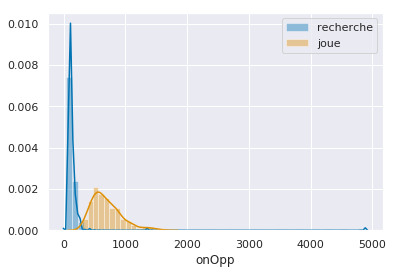

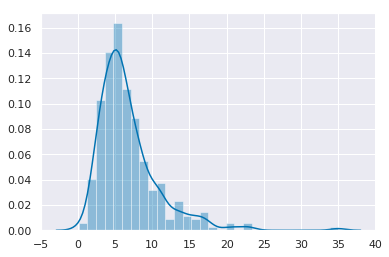

/home/pecoffet/remotedata/bm-iterstart-2019-02-05/canonical_bm/cmaes/r300/2500/run_02/rep00
2499


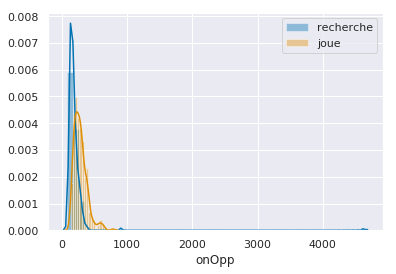

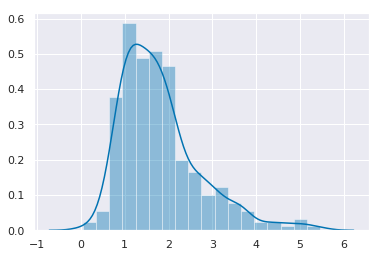

/home/pecoffet/remotedata/bm-iterstart-2019-02-05/canonical_bm/cmaes/r300/2500/run_03/rep00
2499


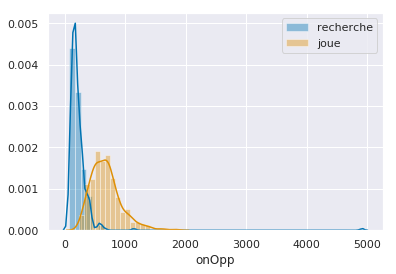

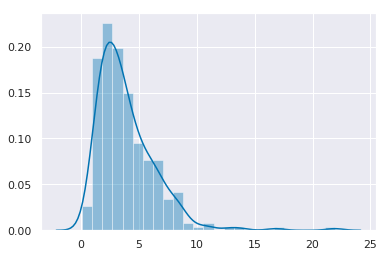

/home/pecoffet/remotedata/bm-iterstart-2019-02-05/canonical_bm/cmaes/r300/2500/run_04/rep00
2499


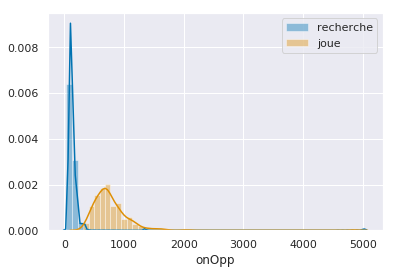

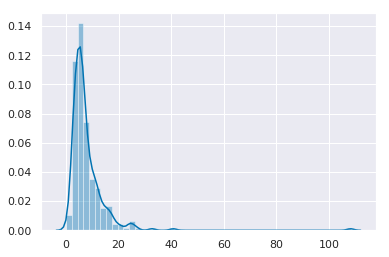

/home/pecoffet/remotedata/bm-iterstart-2019-02-05/canonical_bm/cmaes/r300/2500/run_05/rep00
2499


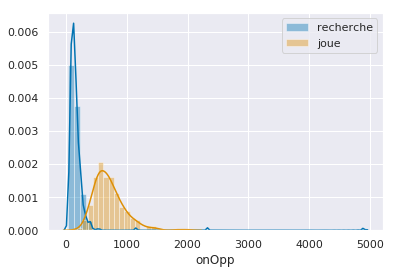

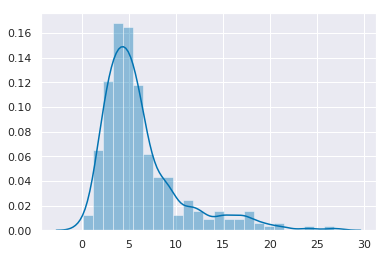

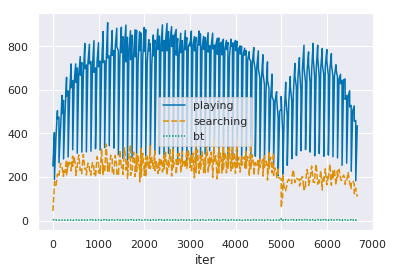

In [30]:
conds = sorted(list(glob("/home/pecoffet/remotedata/bm-iterstart-2019-02-05/canonical_bm/cmaes/r300/2500/**/rep00", recursive=True)))
autogen = True
gen = 0

betataus = []
for cond in conds:
    print(cond)
    if autogen:
        gen = max([int(re.search('logall_(\d+)', fname).group(1)) for fname in glob(join(cond, 'logall_*'))])
        print(gen)
    logfile = join(cond, 'logall_{}.txt'.format(gen))
    i = 0
    ok = True
    to_format = '{' in logfile
    logs = []
    while ok:
        try:
            dat = read_csvx(logfile.format(i), delimiter="\t", nrows=2000000)
            dat["eval"] = i
            logs.append(dat)
        except Exception:
            ok = False
        else:
            i += 1
            ok = to_format
    try:
        log = pd.concat(logs).copy() # Fakes are removed from data
    except Exception as e:
        plt.show(fig)
        print(e)
        print("no data, continue")
        continue
    log['onOpp'] = np.where((log['oppId'] != -1) & (log['meanOwn'] != 0), 1, 0)
    log['notOnOpp'] = log['onOpp'] == False
    wait = log.groupby(['id', 'eval'])['notOnOpp'].apply((lambda x : ifnanthenone(np.nanmean(seqsize(np.array(x))))))
    stay = log.groupby(['id', 'eval'])['onOpp'].apply((lambda x : ifnanthenone(np.nanmean(seqsize(np.array(x))))))
    
    

    beta = 1/wait # Change to is same object for measurement with TP
    tau = 1/stay
    
    waitmean = wait.groupby(['id', 'eval']).apply(np.nanmean)
    staymean = stay.groupby(['id', 'eval']).apply(np.nanmean)
    betataumean = staymean / waitmean
    fig = plt.figure()
    sns.distplot(waitmean, label='recherche')
    sns.distplot(staymean, label='joue')
    plt.legend()
    plt.show(fig)
    plt.close(fig)
    
    
    fig = plt.figure()
    sns.distplot(staymean / waitmean)
    plt.show(fig)
    plt.close(fig)
    

    res = log.groupby(['id', 'eval'])['notOnOpp'].apply((lambda x : todf(np.array(x))))
    res2 = log.groupby(['id', 'eval'])['onOpp'].apply((lambda x : todf(np.array(x))))
    res['betatau'] = res2.groupby('iter')['wait'].apply(np.nanmean) / res.groupby('iter')['wait'].apply(np.nanmean)

    res['beta'] = 1 / res['wait']
    if False:
        fig = plt.figure()
        sns.distplot(beta/tau)
        plt.show(fig)
        plt.close(fig)
        print((beta/tau).mean())
        fig = plt.figure()
        sns.distplot(wait)
        plt.show(fig)
        plt.close(fig)
        fig = plt.figure()
        sns.distplot(stay)
        plt.show(fig)
        plt.close(fig)
        fig = plt.figure()
        sns.lineplot(x='iter', y='beta', data=res.query('iter % 100 == 0'))
        plt.ylim(0, 0.3)
        plt.show(fig)
        plt.close(fig)

        fig = plt.figure()
        sns.lineplot(x='iter', y='wait', data=res.query('iter % 100 == 0'), label="looking")
        sns.lineplot(x='iter', y='wait', data=res2.query('iter % 100 == 0'), label="staying")
        plt.show(fig)
        plt.close(fig)

    betatau = pd.DataFrame()
    betatau['playing'] = res2.groupby('iter')['wait'].agg(np.nanmean)
    betatau['searching'] = res.groupby('iter')['wait'].agg(np.nanmean)
    betatau['bt'] = betatau['playing'] / betatau['searching']
    betataus.append(pd.DataFrame(betatau))


dfbetataus = pd.concat(betataus)
sns.lineplot(data=dfbetataus[::100])

In [25]:
stay

id  eval
0   0        768.316694
1   0        310.624345
2   0        567.237071
3   0        867.756672
4   0       1026.082412
5   0        583.861615
6   0        541.206535
7   0        609.437841
8   0        734.703321
9   0        620.895900
10  0        536.323300
11  0        719.327622
12  0        484.744423
13  0        819.679372
14  0        733.670328
15  0        819.575983
16  0        465.284047
17  0        751.409781
18  0        943.188173
19  0        692.698980
20  0       1067.316171
21  0        851.094053
22  0        615.737585
23  0        873.729044
24  0        954.848537
25  0        812.672713
26  0        654.558623
27  0        723.007271
28  0        645.909882
29  0        632.952133
               ...     
70  0        897.058415
71  0        662.755214
72  0        567.582781
73  0        515.433287
74  0        710.660742
75  0        864.423983
76  0        532.707809
77  0        527.047981
78  0        727.193338
79  0        619.583032
80  0  

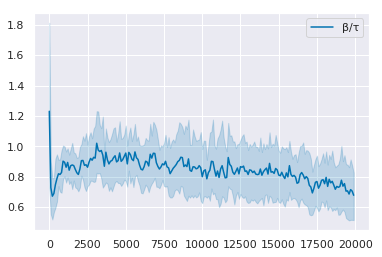

In [128]:
dfbetataus = pd.concat(betataus)

sns.lineplot(data=dfbetataus[::100]['bt'], label="β/τ")
plt.legend()

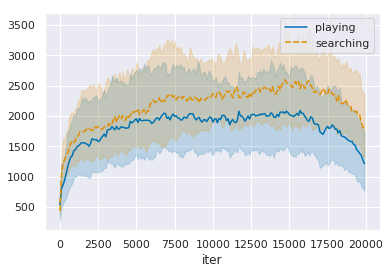

In [129]:
sns.lineplot(data=dfbetataus[::100][['playing', 'searching']])

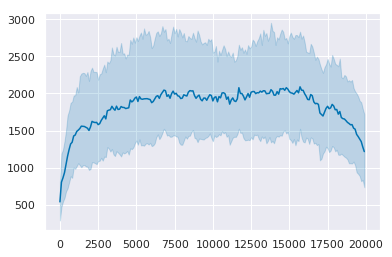

In [130]:
sns.lineplot(data=dfbetataus[::100]['playing'])

In [131]:
log.query('nbOnOpp == 2 and meanOwn == 0')

,eval,iter,id,a,fakeCoef,playing,oppId,nbOnOpp,curCoop,meanOwn,meanTotal,punish,spite,onOpp,notOnOpp
2255,0,22,55,5,0.604927,0,11,2,1.378340,0.0,0.0,0,0,0,True
2355,0,23,55,5,0.604927,0,11,2,1.378340,0.0,0.0,0,0,0,True
2365,0,23,65,5,0.620880,0,37,2,0.898675,0.0,0.0,0,0,0,True
2455,0,24,55,5,0.604927,0,11,2,1.378340,0.0,0.0,0,0,0,True
2465,0,24,65,5,0.620880,0,37,2,0.898675,0.0,0.0,0,0,0,True
2555,0,25,55,5,0.604927,0,11,2,1.378340,0.0,0.0,0,0,0,True
2565,0,25,65,5,0.620880,0,37,2,0.898675,0.0,0.0,0,0,0,True
2655,0,26,55,5,0.604927,0,11,2,1.378340,0.0,0.0,0,0,0,True
2665,0,26,65,5,0.620880,0,37,2,0.898675,0.0,0.0,0,0,0,True
2755,0,27,55,5,0.604927,0,11,2,1.378340,0.0,0.0,0,0,0,True


In [165]:
timebetataus = []
indbetataus = []
evos = ['fitprop']
tps = ['canonical_bm', 'canonical_bm_tp']
for evo in evos:
    for tp in tps:
        tpword = 'avec' if 'tp' in tp else 'sans'
        for decay in [100, 500, 1000, 5000]:

            conds = sorted(list(glob(f"../../../logs/bm-decay-test-2019-01-*/{tp}/{decay}/{evo}/**/run_*/rep00", recursive=True)))
            print(conds)
            autogen = True
            gen = 0

            for cond in conds:
                print(cond)
                if autogen:
                    gen = max([int(re.search('logall_(\d+)', fname).group(1)) for fname in glob(join(cond, 'logall_*'))])
                    print(gen)
                logfile = join(cond, 'logall_{}.txt'.format(gen))
                i = 0
                ok = True
                to_format = '{' in logfile
                logs = []
                while ok:
                    try:
                        dat = read_csvx(logfile.format(i), delimiter="\t", nrows=2000000)
                        dat["eval"] = i
                        logs.append(dat)
                    except Exception:
                        ok = False
                    else:
                        i += 1
                        ok = to_format
                try:
                    log = pd.concat(logs).copy() # Fakes are removed from data
                except Exception as e:
                    plt.show(fig)
                    print(e)
                    print("no data, continue")
                    continue
                log['onOpp'] = np.where((log['oppId'] != -1) & (log['meanOwn'] != 0), 1, 0)
                log['notOnOpp'] = log['onOpp'] == False
                wait = log.groupby(['id', 'eval'])['notOnOpp'].apply((lambda x : ifnanthenone(np.nanmean(seqsize(np.array(x))))))
                stay = log.groupby(['id', 'eval'])['onOpp'].apply((lambda x : ifnanthenone(np.nanmean(seqsize(np.array(x))))))

                beta = 1/wait # Change to is same object for measurement with TP
                tau = 1/stay

                waitmean = log.groupby(['id', 'eval'])['notOnOpp'].apply(lambda x : meanseqsizeonce(np.array(x)))
                staymean = log.groupby(['id', 'eval'])['onOpp'].apply(lambda x : meanseqsizeonce(np.array(x)))

                indbetatau = pd.DataFrame()
                indbetatau['wait'] = waitmean
                indbetatau['stay'] = staymean
                indbetatau['decay'] = decay
                indbetatau['evo'] = evo
                indbetatau['tp'] = tpword

                indbetataus.append(indbetatau)

                if False:
                    fig = plt.figure()
                    sns.distplot(waitmean, label='recherche')
                    sns.distplot(staymean, label='joue')
                    plt.legend()
                    plt.show(fig)
                    plt.close(fig)

                    fig = plt.figure()
                    sns.distplot(staymean / waitmean)
                    plt.show(fig)
                    plt.close(fig)


                res = log.groupby(['id', 'eval'])['notOnOpp'].apply((lambda x : todf(np.array(x))))
                res2 = log.groupby(['id', 'eval'])['onOpp'].apply((lambda x : todf(np.array(x))))
                res['betatau'] = res2.groupby('iter')['wait'].apply(np.nanmean) / res.groupby('iter')['wait'].apply(np.nanmean)

                res['beta'] = 1 / res['wait']
                if False:
                    fig = plt.figure()
                    sns.distplot(beta/tau)
                    plt.show(fig)
                    plt.close(fig)
                    print((beta/tau).mean())
                    fig = plt.figure()
                    sns.distplot(wait)
                    plt.show(fig)
                    plt.close(fig)
                    fig = plt.figure()
                    sns.distplot(stay)
                    plt.show(fig)
                    plt.close(fig)
                    fig = plt.figure()
                    sns.lineplot(x='iter', y='beta', data=res.query('iter % 100 == 0'))
                    plt.ylim(0, 0.3)
                    plt.show(fig)
                    plt.close(fig)

                    fig = plt.figure()
                    sns.lineplot(x='iter', y='wait', data=res.query('iter % 100 == 0'), label="looking")
                    sns.lineplot(x='iter', y='wait', data=res2.query('iter % 100 == 0'), label="staying")
                    plt.show(fig)
                    plt.close(fig)

                betatau = pd.DataFrame()
                betatau['playing'] = res2.groupby('iter')['wait'].agg(np.nanmean)
                betatau['searching'] = res.groupby('iter')['wait'].agg(np.nanmean)
                betatau['bt'] = betatau['playing'] / betatau['searching']
                betatau['decay'] = decay
                betatau['evo'] = evo
                betatau['tp'] = tpword
                timebetataus.append(pd.DataFrame(betatau))

['../../../logs/bm-decay-test-2019-01-27/canonical_bm/100/cmaes/run_01/rep00', '../../../logs/bm-decay-test-2019-01-27/canonical_bm/100/cmaes/run_02/rep00', '../../../logs/bm-decay-test-2019-01-27/canonical_bm/100/cmaes/run_03/rep00', '../../../logs/bm-decay-test-2019-01-27/canonical_bm/100/cmaes/run_04/rep00', '../../../logs/bm-decay-test-2019-01-27/canonical_bm/100/cmaes/run_05/rep00', '../../../logs/bm-decay-test-2019-01-27/canonical_bm/100/cmaes/run_06/rep00', '../../../logs/bm-decay-test-2019-01-27/canonical_bm/100/cmaes/run_07/rep00', '../../../logs/bm-decay-test-2019-01-27/canonical_bm/100/cmaes/run_08/rep00']
../../../logs/bm-decay-test-2019-01-27/canonical_bm/100/cmaes/run_01/rep00
999


/home/ecoffet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice
/home/ecoffet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: Mean of empty slice


../../../logs/bm-decay-test-2019-01-27/canonical_bm/100/cmaes/run_02/rep00
499
../../../logs/bm-decay-test-2019-01-27/canonical_bm/100/cmaes/run_03/rep00
499
../../../logs/bm-decay-test-2019-01-27/canonical_bm/100/cmaes/run_04/rep00
499
../../../logs/bm-decay-test-2019-01-27/canonical_bm/100/cmaes/run_05/rep00
999
../../../logs/bm-decay-test-2019-01-27/canonical_bm/100/cmaes/run_06/rep00
499
../../../logs/bm-decay-test-2019-01-27/canonical_bm/100/cmaes/run_07/rep00
499
../../../logs/bm-decay-test-2019-01-27/canonical_bm/100/cmaes/run_08/rep00
499
['../../../logs/bm-decay-test-2019-01-28/canonical_bm/500/cmaes/run_01/rep00', '../../../logs/bm-decay-test-2019-01-28/canonical_bm/500/cmaes/run_02/rep00', '../../../logs/bm-decay-test-2019-01-28/canonical_bm/500/cmaes/run_03/rep00', '../../../logs/bm-decay-test-2019-01-28/canonical_bm/500/cmaes/run_04/rep00', '../../../logs/bm-decay-test-2019-01-28/canonical_bm/500/cmaes/run_05/rep00', '../../../logs/bm-decay-test-2019-01-28/canonical_bm/500

/home/ecoffet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/home/ecoffet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: Mean of empty slice


../../../logs/bm-decay-test-2019-01-28/canonical_bm_tp/5000/cmaes/run_04/rep00
499
../../../logs/bm-decay-test-2019-01-28/canonical_bm_tp/5000/cmaes/run_05/rep00
499
../../../logs/bm-decay-test-2019-01-28/canonical_bm_tp/5000/cmaes/run_06/rep00
499
../../../logs/bm-decay-test-2019-01-28/canonical_bm_tp/5000/cmaes/run_07/rep00
499
../../../logs/bm-decay-test-2019-01-28/canonical_bm_tp/5000/cmaes/run_08/rep00
499
['../../../logs/bm-decay-test-2019-01-27/canonical_bm/100/fitprop/run_01/rep00', '../../../logs/bm-decay-test-2019-01-27/canonical_bm/100/fitprop/run_02/rep00', '../../../logs/bm-decay-test-2019-01-27/canonical_bm/100/fitprop/run_03/rep00', '../../../logs/bm-decay-test-2019-01-27/canonical_bm/100/fitprop/run_04/rep00', '../../../logs/bm-decay-test-2019-01-27/canonical_bm/100/fitprop/run_05/rep00', '../../../logs/bm-decay-test-2019-01-27/canonical_bm/100/fitprop/run_06/rep00', '../../../logs/bm-decay-test-2019-01-27/canonical_bm/100/fitprop/run_07/rep00', '../../../logs/bm-decay-

KeyboardInterrupt: 

In [169]:
dfindbetataus = pd.concat(indbetataus)

In [171]:
dfindbetataus['bt'] = dfindbetataus['stay'] / dfindbetataus['wait']

Text(0.5, 1.0, 'Distribution des β/τ de chaque agent, CMA-ES, 20000 iterations, déplacement')

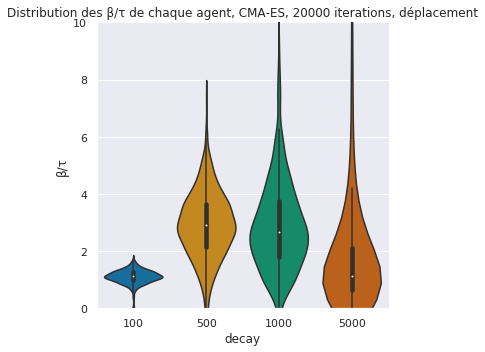

In [218]:
sns.catplot(data=dfindbetataus.query('tp == "sans"'), x='decay', y='bt', col='tp', kind='violin', scale='width')
plt.ylim(0, 10)
plt.ylabel("β/τ")
plt.title('Distribution des β/τ de chaque agent, CMA-ES, 20000 iterations, déplacement')

Text(0.5, 1.0, 'distribution des temps restés sur un objet, CMA-ES, 20000 iterations, déplacement')

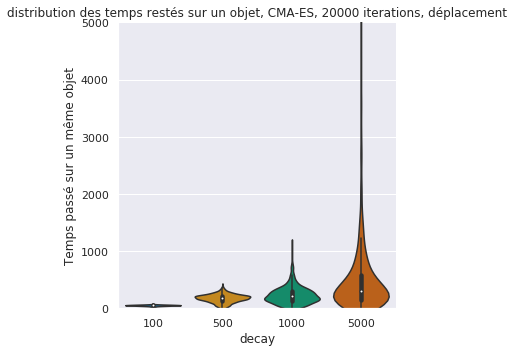

In [219]:
sns.catplot(data=dfindbetataus.query('tp == "sans"'), x='decay', y='stay', col='tp', kind="violin", scale='width')
plt.ylim(0, 5000)
plt.ylabel('Temps passé sur un même objet')
plt.title('distribution des temps restés sur un objet, CMA-ES, 20000 iterations, déplacement')

Text(0.5, 1.0, 'Distribution des temps passés à trouver un objet, CMA-ES, 20000 iterations, déplacement')

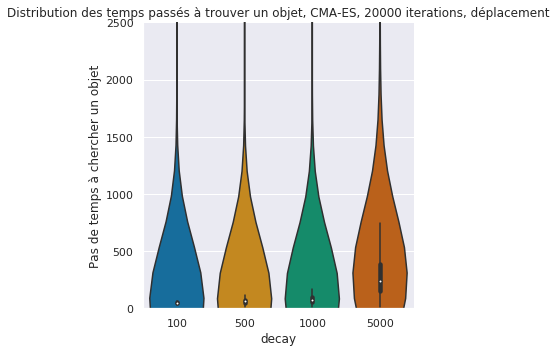

In [222]:
sns.catplot(data=dfindbetataus.query('tp == "sans"'), x='decay', y='wait', col='tp', kind='violin', scale='width')
plt.ylim(0, 2500)
plt.ylabel('Pas de temps à chercher un objet')
plt.title('Distribution des temps passés à trouver un objet, CMA-ES, 20000 iterations, déplacement')

In [224]:
dftimebetataus = pd.concat(timebetataus)

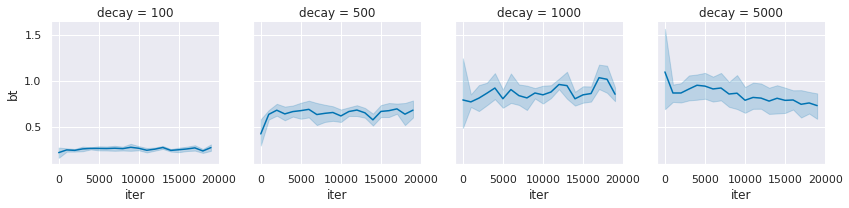

In [249]:
g = sns.FacetGrid(data=dftimebetataus.query('tp == "sans" and iter % 1000 == 0'), col='decay', sharex=True, sharey=True)
g.map(sns.lineplot, "iter", "bt")

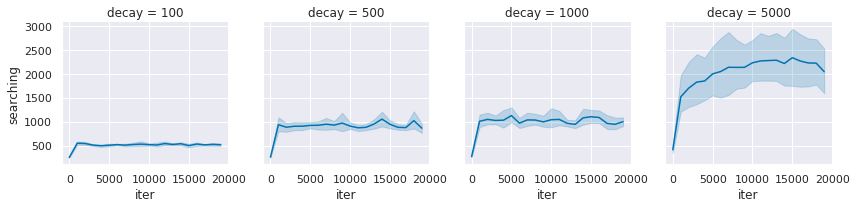

In [254]:
g = sns.FacetGrid(data=dftimebetataus.query('tp == "sans" and iter % 1000 == 0'), col='decay', sharex=True, sharey=True)
g.map(sns.lineplot, "iter", "searching")


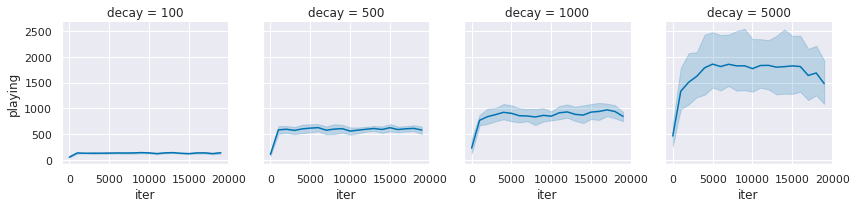

In [255]:
g = sns.FacetGrid(data=dftimebetataus.query('tp == "sans" and iter % 1000 == 0'), col='decay', sharex=True, sharey=True)
g.map(sns.lineplot, "iter", "playing")


In [233]:
dftimebetataus = dftimebetataus.reset_index()

In [239]:
dftimebetataus

,iter,playing,searching,bt,decay,evo,tp
0,0,57.066667,263.858824,0.216277,100,cmaes,sans
1,1,54.277778,274.658537,0.197619,100,cmaes,sans
2,2,54.315789,278.148148,0.195276,100,cmaes,sans
3,3,53.913043,292.441558,0.184355,100,cmaes,sans
4,4,62.185185,308.246575,0.201738,100,cmaes,sans
5,5,60.892857,312.458333,0.194883,100,cmaes,sans
6,6,67.600000,300.626667,0.224864,100,cmaes,sans
7,7,67.148148,308.917808,0.217366,100,cmaes,sans
8,8,71.068966,317.591549,0.223775,100,cmaes,sans
9,9,74.656250,331.205882,0.225407,100,cmaes,sans
